In [19]:
# 1. traditional backwards feature selection: take a feature out, retrain model without feature and see how performance changed. features who droppage least affects the
# model performance have love impact on predictive performance and should be permanently dropped
# 2. sensitivity analysis +backwards elimination feature selection. measuring how variance in each feature affects the output. THis method has different variants depending on the exact model
# (look into partial dependence plots)

In [20]:
%pip install ucimlrepo

###Loading the data set

In [21]:
from ucimlrepo import fetch_ucirepo
from ucimlrepo import list_available_datasets


# fetch dataset
wine_quality = fetch_ucirepo(id=186)


# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets



#X.head()
#y.head()
# variable information
#print(wine_quality.variables)

###Data Preprocessing: want to understand how the data is distributed and perfoming cleaning if necesary

<Axes: xlabel='quality'>

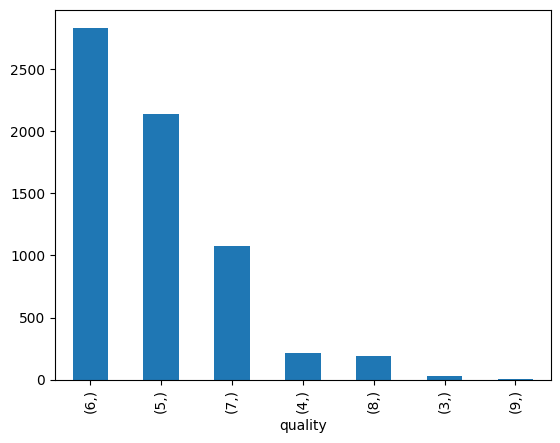

In [22]:
# histogram to give an idea of how imbalanced the quality is
#from matplotlib import pyplot as plt
#import seaborn as sns

y.value_counts().plot(kind='bar')

In [23]:
#X.describe()

#Model A (without sampling)



In [24]:
!pip install imbalanced-learn

###Split the data

In [25]:
from sklearn.model_selection import train_test_split
import pandas as pd

y_flat = y.values.ravel()
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

best_models = []

###Check for imbalance in the training split

<Axes: xlabel='0'>

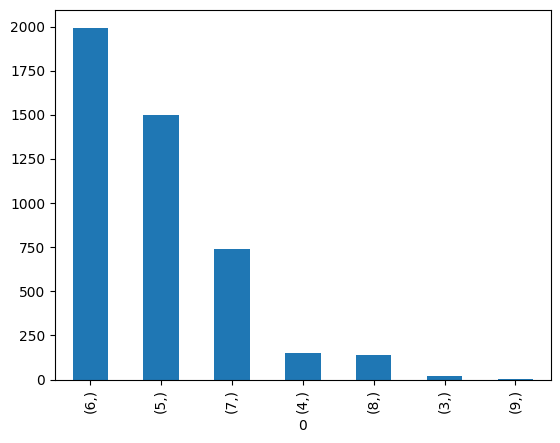

In [26]:
(pd.DataFrame(y_train)).value_counts().plot(kind='bar')

###I think its natural to have more normal wines that excellent ones so I would model with and without imbalance handling

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Hyperparameters to try
max_depths = [8, 10]
min_samples_splits = [10,14,20]
min_samples_leafs = [3, 5,8]
max_features_values = ['sqrt', 'log2', 3, 5]  # if few features
class_weights = ['balanced', None]
ccp_alphas = [0.0, 0.001, 0.005, 0.01]

DecisionTree_results = []

# Grid search loop
for depth in max_depths:
    for split in min_samples_splits:
        for min_sample in min_samples_leafs:
            for max_feature in max_features_values:
                for class_weight in class_weights:
                  for alpha in ccp_alphas:

                    # Define Decision Tree model
                    DT_model = DecisionTreeClassifier(
                        ccp_alpha=alpha,
                        class_weight=class_weight,
                        min_samples_leaf=min_sample,
                        max_depth=depth,
                        min_samples_split=split,
                        max_features=max_feature,
                        random_state=17
                    )
                    DT_model.fit(X_train, y_train)

                    # Train performance
                    DT_y_train_pred = DT_model.predict(X_train)
                    T_accuracy = accuracy_score(y_train, DT_y_train_pred)
                    T_precision = precision_score(y_train, DT_y_train_pred, average='macro', zero_division=np.nan)
                    T_recall = recall_score(y_train, DT_y_train_pred, average='macro')
                    T_f1 = f1_score(y_train, DT_y_train_pred, average='macro')

                    # Validation performance
                    DT_y_val_pred = DT_model.predict(X_val)
                    V_accuracy = accuracy_score(y_val, DT_y_val_pred)
                    V_precision = precision_score(y_val, DT_y_val_pred, average='macro', zero_division=np.nan)
                    V_recall = recall_score(y_val, DT_y_val_pred, average='macro')
                    V_f1 = f1_score(y_val, DT_y_val_pred, average='macro')

                    # Save results
                    DecisionTree_results.append({
                        'Type': 'pure_Non_FS',
                        'T_accuracy': T_accuracy,
                        'T_precision': T_precision,
                        'T_recall': T_recall,
                        'T_f1': T_f1,
                        'ccp_alpha':alpha,
                        'max_features': max_feature,
                        'max_depth': depth,
                        'min_samples_split': split,
                        'class_weight':class_weight,
                        'min_samples_leaf':min_sample,
                        'V_accuracy': V_accuracy,
                        'V_precision': V_precision,
                        'V_recall': V_recall,
                        'V_f1': V_f1
                    })

# Create dataframe
DecisionTree_result_df = pd.DataFrame(DecisionTree_results)

# Sort by validation accuracy
DecisionTree_result_df.sort_values(by='V_accuracy', ascending=False, inplace=True)
DecisionTree_result_df.reset_index(drop=True, inplace=True)

# Best model
best_DecisionTree = DecisionTree_result_df.iloc[0].to_dict()
best_models.append(best_DecisionTree)

print(f'Best Decision Tree: {best_DecisionTree}')

DecisionTree_result_df

Best Decision Tree: {'Type': 'pure_Non_FS', 'T_accuracy': 0.6694523861886958, 'T_precision': 0.631819768282522, 'T_recall': 0.35172290836895453, 'T_f1': 0.37982166537126133, 'ccp_alpha': 0.0, 'max_features': 5, 'max_depth': 10, 'min_samples_split': 14, 'class_weight': None, 'min_samples_leaf': 8, 'V_accuracy': 0.5641025641025641, 'V_precision': 0.41612461344186286, 'V_recall': 0.2560845957144981, 'V_f1': 0.2646575030393135}


,Type,T_accuracy,T_precision,T_recall,T_f1,ccp_alpha,max_features,max_depth,min_samples_split,class_weight,min_samples_leaf,V_accuracy,V_precision,V_recall,V_f1
0,pure_Non_FS,0.669452,0.631820,0.351723,0.379822,0.000,5,10,14,None,8,0.564103,0.416125,0.256085,0.264658
1,pure_Non_FS,0.669452,0.631820,0.351723,0.379822,0.000,5,10,10,None,8,0.564103,0.416125,0.256085,0.264658
2,pure_Non_FS,0.597317,0.644677,0.270200,0.287010,0.001,5,10,20,None,3,0.561026,0.433777,0.239145,0.243261
3,pure_Non_FS,0.594898,0.633625,0.269273,0.288124,0.001,3,10,20,None,8,0.554872,0.527629,0.238763,0.249123
4,pure_Non_FS,0.594898,0.633625,0.269273,0.288124,0.001,log2,10,20,None,8,0.554872,0.527629,0.238763,0.249123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,pure_Non_FS,0.213108,0.239905,0.467489,0.153006,0.010,log2,8,14,balanced,8,0.197949,0.179986,0.210104,0.118253
572,pure_Non_FS,0.196833,0.261354,0.555511,0.178630,0.005,log2,8,10,balanced,3,0.188718,0.232921,0.232552,0.114119
573,pure_Non_FS,0.196833,0.261354,0.555511,0.178630,0.005,sqrt,8,10,balanced,3,0.188718,0.232921,0.232552,0.114119
574,pure_Non_FS,0.196833,0.261354,0.555511,0.178630,0.005,3,8,10,balanced,3,0.188718,0.232921,0.232552,0.114119


#Modeling with SMOTE

In [29]:
#We are resplitting the data because we have already performing scaling in the experiments above
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

In [30]:
# counting the number of classes in train
#from collections import Counter
#print (Counter(y_train))

In [31]:
#handling imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=17,k_neighbors=2)
# prefixing with s to indicate smote
sX_train, sy_train = smote.fit_resample(X_train, y_train)

In [32]:
# scaling
scaler = StandardScaler()
sX_train = scaler.fit_transform(sX_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [33]:
# Hyperparameters to try
max_depths = [8, 30,20]
min_samples_splits = [10,14,20]
min_samples_leafs = [3, 5,8]
max_features_values = ['sqrt', 'log2', 3, 5]  # if few features
ccp_alphas = [0.0, 0.001, 0.005, 0.01]

DecisionTree_results = []

# Grid search loop
for depth in max_depths:
    for split in min_samples_splits:
        for min_sample in min_samples_leafs:
            for max_feature in max_features_values:
                  for alpha in ccp_alphas:

                    # Define Decision Tree model
                    DT_model = DecisionTreeClassifier(
                        ccp_alpha=alpha,
                        min_samples_leaf=min_sample,
                        max_depth=depth,
                        min_samples_split=split,
                        max_features=max_feature,
                        random_state=17
                    )
                    DT_model.fit(sX_train, sy_train)

                    # Train performance
                    DT_y_train_pred = DT_model.predict(sX_train)
                    T_accuracy = accuracy_score(sy_train, DT_y_train_pred)
                    T_precision = precision_score(sy_train, DT_y_train_pred, average='macro', zero_division=np.nan)
                    T_recall = recall_score(sy_train, DT_y_train_pred, average='macro')
                    T_f1 = f1_score(sy_train, DT_y_train_pred, average='macro')

                    # Validation performance
                    DT_y_val_pred = DT_model.predict(X_val)
                    V_accuracy = accuracy_score(y_val, DT_y_val_pred)
                    V_precision = precision_score(y_val, DT_y_val_pred, average='macro', zero_division=np.nan)
                    V_recall = recall_score(y_val, DT_y_val_pred, average='macro')
                    V_f1 = f1_score(y_val, DT_y_val_pred, average='macro')

                    # Save results
                    DecisionTree_results.append({
                        'Type': 'smote_Non_FS',
                        'T_accuracy': T_accuracy,
                        'T_precision': T_precision,
                        'T_recall': T_recall,
                        'T_f1': T_f1,
                        'max_features': max_feature,
                        'ccp_alpha':alpha,
                        'max_depth': depth,
                        'min_samples_split': split,
                        'class_weight':None,
                        'min_samples_leaf':min_sample,
                        'V_accuracy': V_accuracy,
                        'V_precision': V_precision,
                        'V_recall': V_recall,
                        'V_f1': V_f1
                    })

# Create dataframe
DecisionTree_result_df = pd.DataFrame(DecisionTree_results)

# Sort by validation accuracy
DecisionTree_result_df.sort_values(by='V_accuracy', ascending=False, inplace=True)
DecisionTree_result_df.reset_index(drop=True, inplace=True)

# Best model
best_DecisionTree = DecisionTree_result_df.iloc[0].to_dict()
best_models.append(best_DecisionTree)

print(f'Best Decision Tree: {best_DecisionTree}')

DecisionTree_result_df


Best Decision Tree: {'Type': 'smote_Non_FS', 'T_accuracy': 0.8894540765152601, 'T_precision': 0.8879676123269004, 'T_recall': 0.88945407651526, 'T_f1': 0.8885284951993511, 'max_features': 5, 'ccp_alpha': 0.0, 'max_depth': 20, 'min_samples_split': 10, 'class_weight': None, 'min_samples_leaf': 5, 'V_accuracy': 0.5169230769230769, 'V_precision': 0.28883438604360584, 'V_recall': 0.3219199389624774, 'V_f1': 0.2962103285010226}


,Type,T_accuracy,T_precision,T_recall,T_f1,max_features,ccp_alpha,max_depth,min_samples_split,class_weight,min_samples_leaf,V_accuracy,V_precision,V_recall,V_f1
0,smote_Non_FS,0.889454,0.887968,0.889454,0.888528,5,0.00,20,10,None,5,0.516923,0.288834,0.321920,0.296210
1,smote_Non_FS,0.887663,0.886143,0.887663,0.886756,sqrt,0.00,30,14,None,3,0.513846,0.283140,0.307711,0.287563
2,smote_Non_FS,0.887663,0.886143,0.887663,0.886756,log2,0.00,30,14,None,3,0.513846,0.283140,0.307711,0.287563
3,smote_Non_FS,0.887663,0.886143,0.887663,0.886756,3,0.00,30,14,None,3,0.513846,0.283140,0.307711,0.287563
4,smote_Non_FS,0.893180,0.891917,0.893180,0.892217,5,0.00,30,10,None,5,0.506667,0.346565,0.350951,0.310782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,smote_Non_FS,0.441897,0.475966,0.441897,0.375989,sqrt,0.01,20,14,None,5,0.074872,0.074409,0.205675,0.066686
428,smote_Non_FS,0.441897,0.475966,0.441897,0.375989,log2,0.01,20,14,None,5,0.074872,0.074409,0.205675,0.066686
429,smote_Non_FS,0.428930,0.460860,0.428930,0.357233,3,0.01,20,20,None,3,0.068718,0.078143,0.175252,0.068066
430,smote_Non_FS,0.428930,0.460860,0.428930,0.357233,sqrt,0.01,20,20,None,3,0.068718,0.078143,0.175252,0.068066


#Choosing a the best model for feature selection



In [34]:
#analyzing the top models in every experiment above to pick the best one
best_models_df = pd.DataFrame(best_models)
#best_models_df.drop( columns=['Type', 'accuracy', 'precision', 'recall', 'f1'], inplace=True)

chosen_one = best_models_df.iloc[0]
chosen_one =chosen_one[['ccp_alpha', 'max_features', 'max_depth', 'min_samples_split', 'class_weight', 'min_samples_leaf']].to_dict()

print(chosen_one)
best_models_df


{'ccp_alpha': 0.0, 'max_features': 5, 'max_depth': 10, 'min_samples_split': 14, 'class_weight': None, 'min_samples_leaf': 8}


,Type,T_accuracy,T_precision,T_recall,T_f1,ccp_alpha,max_features,max_depth,min_samples_split,class_weight,min_samples_leaf,V_accuracy,V_precision,V_recall,V_f1
0,pure_Non_FS,0.669452,0.631820,0.351723,0.379822,0.0,5,10,14,None,8,0.564103,0.416125,0.256085,0.264658
1,smote_Non_FS,0.889454,0.887968,0.889454,0.888528,0.0,5,20,10,None,5,0.516923,0.288834,0.321920,0.296210


#Feature Selection

In [35]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold


#resplitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

# have t make sure we feed the same data structures to the model
'''y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)
y_val =   pd.DataFrame(y_val)'''

#rescaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_val = pd.DataFrame(scaler.transform(X_val),columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns)

#declaring the chosen estimator and passing in best parameters
estimator = DecisionTreeClassifier(**chosen_one,  random_state=17)

sfs = SequentialFeatureSelector(
    estimator=estimator,
    direction='backward',
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3), #ensuring that each fold maintains the same proportion of classes as the original dataset
    n_jobs=-1
)

sfs.fit(X_train, y_train)

selected_features = X.columns[sfs.get_support()]


FS_X_train = X_train[selected_features]
FS_X_val = X_val[selected_features]
FS_X_test = X_test[selected_features]
print('Selected features: ', selected_features )



Selected features:  Index(['fixed_acidity', 'volatile_acidity', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'alcohol'],
      dtype='object')


# Fitting Final Model and Performing Evaluation

In [36]:
estimator.fit(FS_X_train, y_train)

# make predictions on test
y_test_pred = estimator.predict(FS_X_test)

# compute metrics for test
accuracy = accuracy_score(y_test, y_test_pred)
macro_precision = precision_score(y_test, y_test_pred, average='macro',zero_division=np.nan)
macro_recall = recall_score(y_test, y_test_pred, average='macro')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
weighted_precision = precision_score(y_test, y_test_pred, average='weighted',zero_division=np.nan)
weighted_recall = recall_score(y_test, y_test_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')


eval_stats = {'Type': 'Decision Tree',
      'accuracy' : accuracy,
      'macro_precision' : macro_precision,
      'weighted_precision' : weighted_precision,
      'macro_recall' : macro_recall,
      'weighted_recall' : weighted_recall,
      'macro_f1' : macro_f1,
      'weighted_f1' : weighted_f1,
      'ccp_alpha':estimator.get_params()['ccp_alpha'],
      'max_features':estimator.get_params()['max_features'],
      'max_depth':estimator.get_params()['max_depth'],
      'min_samples_split':estimator.get_params()['min_samples_split'],
      'class_weight':estimator.get_params()['class_weight'],
      'min_samples_leaf':estimator.get_params()['min_samples_leaf']
}


print (eval_stats)

{'Type': 'Decision Tree', 'accuracy': 0.5230769230769231, 'macro_precision': 0.4098490454740455, 'weighted_precision': 0.5052912697307027, 'macro_recall': 0.23749078758631695, 'weighted_recall': 0.5230769230769231, 'macro_f1': 0.24594765595722942, 'weighted_f1': 0.5046602931725791, 'ccp_alpha': 0.0, 'max_features': 5, 'max_depth': 10, 'min_samples_split': 14, 'class_weight': None, 'min_samples_leaf': 8}
